# Portfolio Optimization Study

In this notebook we explore the data and compute the portfolio

#### Read processed data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

csv = 'processed/data.csv'
if not os.path.isfile(csv):
    %run "./wrangle.ipynb";
    
df = pd.read_csv(csv, parse_dates=True, index_col="Data");

## Data Exploration

### Correlations

We set the starting year $ y_0 $ and the last year $ y_n $ and calculate de log returns $ ln(t_n) - ln(t_{n-1}) $

In [2]:
y_0, y_1 = '2011', '2021'
tickers = ['IMA-B', 'IFIX', 'IBOV', 'BDRX', 'DOLOF', 'NASDAQ', 'S&P 500', 'DJIA', 'WTICO', 'EURUSD']
data = df[y_0:y_1][tickers].copy()
lreturns = np.log( data ) - np.log( data.shift(1) )
lreturns

C:\Users\Marcus Santos\.conda\envs\portfolio\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,IMA-B,IFIX,IBOV,BDRX,DOLOF,NASDAQ,S&P 500,DJIA,WTICO,EURUSD
Data,,,,,,,,,,
2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,-0.001208,-0.008577,0.005061,0.009412,0.002782,-0.003823,-0.001330,0.001749,-0.024313,-0.005258
2011-01-05,-0.000932,0.006117,0.010947,0.015203,0.009438,0.007783,0.004995,0.002709,0.010129,-0.009382
2011-01-06,-0.001144,-0.002346,-0.007242,0.007277,0.008579,0.002842,-0.002125,-0.002184,-0.021605,-0.012160
2011-01-07,-0.003559,0.004516,-0.007409,-0.005355,0.000237,-0.002483,-0.001847,-0.001930,-0.003401,-0.006872
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-0.000321,0.006978,0.006302,0.001678,0.001042,0.013824,0.013744,0.009739,0.023836,0.000557
2021-12-28,-0.000163,0.008832,-0.006561,-0.001916,-0.003749,-0.005658,-0.001011,0.002636,0.005411,0.001184
2021-12-29,-0.004236,0.007666,-0.007244,0.014067,0.003202,-0.000983,0.001401,0.002481,0.007605,-0.000186


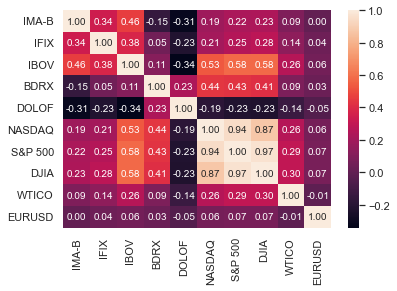

In [3]:
sns.heatmap(lreturns.corr(), annot=True, fmt='.2f');

We find strong correlations between `NASDAQ`, `S&P 500` and `DJIA`

Dropping `NASDAQ` & `DJIA`

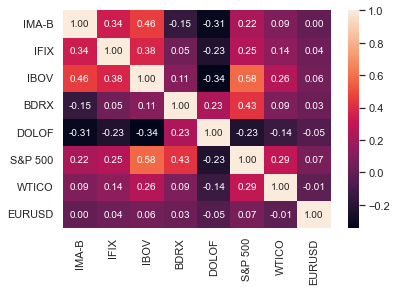

In [4]:
lreturns.drop(columns=['DJIA', 'NASDAQ'], inplace=True)
sns.heatmap(lreturns.corr(), annot=True, fmt='.2f');

### Explore the log returns

#### Descriptive Statitcs

In [5]:
lreturns.describe()

,IMA-B,IFIX,IBOV,BDRX,DOLOF,S&P 500,WTICO,EURUSD
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2867.000000,2869.000000
mean,0.000423,0.000359,0.000141,0.000927,0.000425,0.000460,0.000183,-0.000057
std,0.004935,0.005320,0.015562,0.013271,0.008965,0.010619,0.028736,0.005189
min,-0.078184,-0.141912,-0.159938,-0.303322,-0.060686,-0.127660,-0.281382,-0.085217
25%,-0.001339,-0.001407,-0.007838,-0.004464,-0.004191,-0.003179,-0.010556,-0.002134
50%,0.000428,0.000187,0.000000,0.000416,0.000000,0.000418,0.000187,0.000000
75%,0.002526,0.002280,0.008418,0.006672,0.004897,0.005111,0.011001,0.002118
max,0.052596,0.056587,0.130228,0.275915,0.084232,0.089683,0.425832,0.084165


#### Box plots

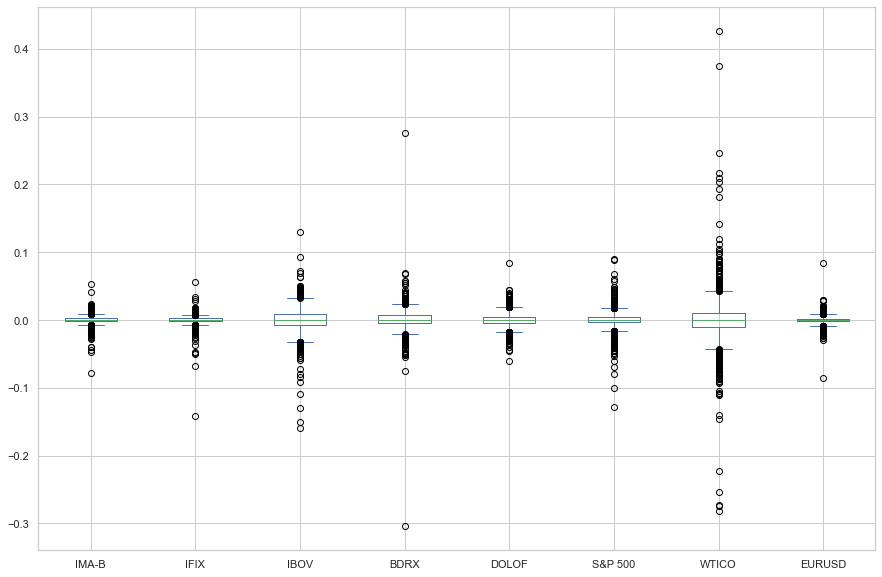

In [6]:
lreturns.plot.box(figsize=(15, 10));

It is possible to observe a lot of outliers in `WTICO`

For a better view of the boxes we set $ Y $ axis to $ [-0.1, 0.1] $

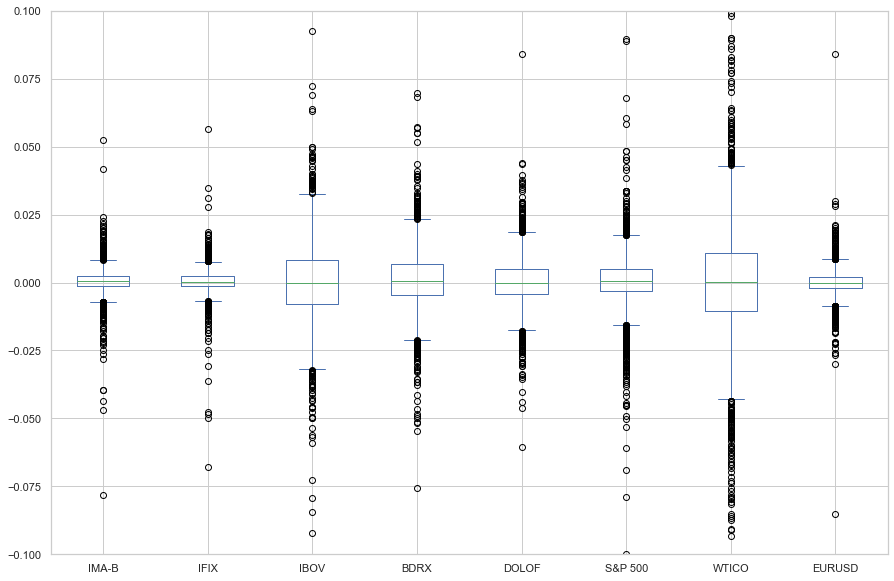

In [7]:
lreturns.plot.box(figsize=(15, 10), ylim=(-0.1, 0.1));

## Basic Markowitz

We use `PyPortfolioOpt`to make a basic Markowitz portfolio with the Mean-Variance Optimization

In [8]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(lreturns, returns_data=True)
S = risk_models.sample_cov(lreturns, returns_data=True)

### Expected Returns

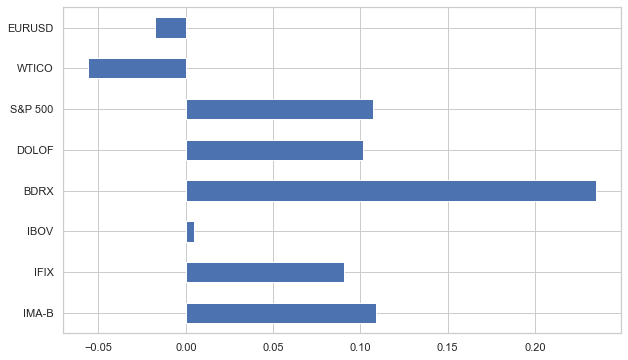

In [9]:
mu.plot.barh(figsize=(10,6));

### Optimize with Max Sharpe

Full date range

In [10]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ex_return, ex_vol, sharpe = ef.portfolio_performance(verbose=True)

Expected annual return: 12.1%
Annual volatility: 5.4%
Sharpe Ratio: 1.88


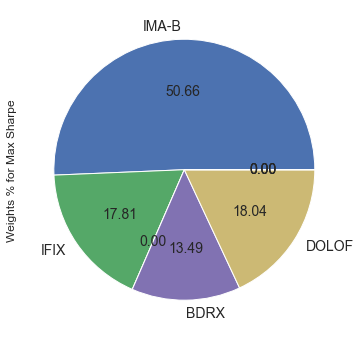

In [11]:
pd.Series(weights, name="Weights % for Max Sharpe").plot.pie(figsize=(6,6), autopct="%.2f", fontsize=14);

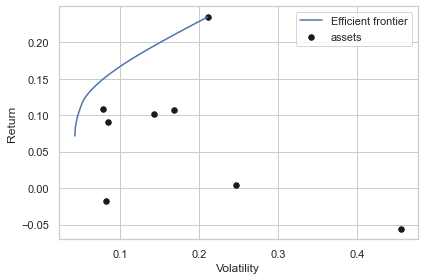

In [12]:
ef2 = EfficientFrontier(mu, S) # workaround for bug https://github.com/robertmartin8/PyPortfolioOpt/issues/373
plotting.plot_efficient_frontier(ef2);